# Диск v1.0

Решение упругопластической задачи в напряжениях для плоского вращающегося кольцевого диска.

Обозначение начального момента времени (для тестов)

In [1]:
import time
start_time = time.time()

Импорт общих модулей и функций

In [2]:
import math
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify
from scipy.optimize import root, root_scalar
plt.rcParams["figure.figsize"] = (5, 5)  # общий размер для всех графиков

Постоянные параметры модели

In [3]:
w = 1
n = 4
s = 1
a = 0.2  # нижняя граница кольца
b = 1    # верхняя граница кольца
k = 1
σ = 0.2
η = 0.7
ν = 0.2

Описание функции пластичности

In [4]:
σr, σt = sy.symbols("sigma_r, sigma_t", real=True)  # напряжения

def f1(σr, σt):
    return σt**w + σr**w
def fT(σr, σt):
    return (σt**(2*n) + σr**(2*n) + (σt - σr)**(2*n)) / 2
def fS(σr, σt):
    return ((2*σt - σr)**(2*s) + (2*σr - σt)**(2*s) + (σt + σr)**(2*s)) / (2 + 2**(2*s))
def fF(σr, σt):
    return (σ*f1(σr, σt)**(1/w) + η*fT(σr, σt)**(1/(2*n)) + (1 - η)*fS(σr, σt)**(1/(2*s))) / (k*(1 + σ)) - 1

# Вывести функцию пластичности
display(sy.Eq(sy.Function("f")(σr, σt), fF(σr, σt)))

Eq(f(sigma_r, sigma_t), 0.166666666666667*(sigma_r + sigma_t)**1.0 + 0.583333333333333*(sigma_r**8/2 + sigma_t**8/2 + (-sigma_r + sigma_t)**8/2)**0.125 + 0.25*((-sigma_r + 2*sigma_t)**2/6 + (sigma_r + sigma_t)**2/6 + (2*sigma_r - sigma_t)**2/6)**0.5 - 1)

## Вычисление предельных параметров функции пластичности

Предварительная оценка

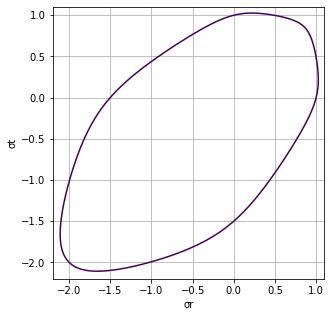

In [5]:
x, y = np.meshgrid(
    np.linspace((-2.2,), (1.1,), 100),
    np.linspace((-2.2,), (1.1,), 100),
)

plt.contour(x, y, fF(x, y), [0])
plt.xlabel("σr")
plt.ylabel("σt")
plt.axis("square")
plt.grid()
plt.show()

Т.о. имеем примерные гранцы:
<div align="center">${\sigma_r}, {\sigma_t} \in (-2.2, 1.1)$</div>

Нахождение более точных предельных значений с помощью scipy

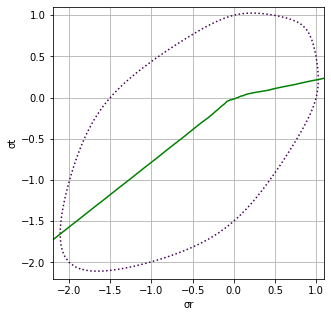

σr_min = -2.107789990794082, σt_in_σr_min = -1.6573172517809858
σr_max = 1.0262403849825052, σt_in_σr_max = 0.21932608047305197
p_max = 2.107789990794082


In [6]:
# иллюстрация меода нахождения предельных значений на графике
x, y = np.meshgrid(
    np.linspace((-2.2,), (1.1,), 50),
    np.linspace((-2.2,), (1.1,), 50),
)

plt.contour(
    x, y,
    fF(x, y),
    [0],
    linestyles='dotted'
)
plt.contour(
    x, y,
    lambdify((σr, σt), fF(σr, σt).diff(σt))(x, y),
    [0],
    colors='g'
)
# plt.contour(
#     x, y,
#     lambdify((σr, σt), fF(σr, σt).diff(σr))(x, y),
#     [0],
#     colors='b'
# )
plt.xlabel("σr")
plt.ylabel("σt")
plt.axis("square")
plt.grid()
plt.show()


# искомые точки - пересечения нуля пластической функции с частными производными
def sigma_limits():
    # чисто визуальные оценки для мин/макс значений σr и σt (см. график)
    estimate_for_min, estimate_for_max = (-2.2, -1.7), (0.2, 1.1)
    
    fF_diff_of_σt = lambdify((σr, σt), fF(σr, σt).diff(σt))
    def σr_limits_wrapper(σ):  return fF_diff_of_σt(σ[0], σ[1]), fF(σ[0], σ[1])
    sol_for_σr_min = root(σr_limits_wrapper, estimate_for_min).x
    sol_for_σr_max = root(σr_limits_wrapper, estimate_for_max).x
    
    # то же самое для σt, в принципе не нужно, но для проверки
#     fF_diff_of_σr = lambdify((σr, σt), fF(σr, σt).diff(σr))
#     def σt_limits_wrapper(σ):  return fF_diff_of_σr(σ[0], σ[1]), fF(σ[0], σ[1])
#     sol_for_σt = root(σt_limits_wrapper, estimate_for_min).x, root(σt_limits_wrapper, estimate_for_max).x
    
    return sol_for_σr_min[0], sol_for_σr_min[1], sol_for_σr_max[0], sol_for_σr_max[1]
    
    
σr_min, σt_in_σr_min, σr_max, σt_in_σr_max = sigma_limits()
p_max = -σr_min

print("σr_min = {}, σt_in_σr_min = {}".format(σr_min, σt_in_σr_min))
print("σr_max = {}, σt_in_σr_max = {}".format(σr_max, σt_in_σr_max))
print("p_max = {}".format(p_max))

## Определение функций, необходимых для решения задачи и построения графиков

Вспомогательная функция, которая находит решения для дифференциалов функций ${\sigma_r}$ и ${\sigma_t}$ по $r$ в пластической зоне

In [7]:
def plastic_eqs():
    m = sy.symbols("m", real=True)  # давление центробежных сил
    r = sy.Symbol("r", real=True)  # радиус

    # функции напряжений и их дифференциалы
    fσr_p = sy.Function("sigma_rp", real=True)(r)
    fσt_p = sy.Function("sigma_tp", real=True)(r)
    d_fσr_p = fσr_p.diff(r)
    d_fσt_p = fσt_p.diff(r)
    
    # уравнение равновесия в пластической зоне (см. Тимошенко)
    eq1 = r * d_fσr_p + fσr_p - fσt_p + m * r**2
    sol_d_fσr_p = sy.solve(eq1, d_fσr_p)[0]  # всегда одно решение
                       
    # в пластической зоне dF/dr = 0 (т.к. в этой зоне F = 1 = const.)
    eq2 = fF(fσr_p, fσt_p).diff(r)
    sol_d_fσt_p = sy.solve(eq2.doit().subs({d_fσr_p: sol_d_fσr_p}), d_fσt_p)[0]  # всегда одно решение
    
#     display(sol_d_fσr_p, sol_d_fσt_p)
    sol_d_fσr_p = lambdify((r, fσr_p, fσt_p, m), sol_d_fσr_p)
    sol_d_fσt_p = lambdify((r, fσr_p, fσt_p, m), sol_d_fσt_p)

    # SCIPY
    def rhs(r, σ_p, m):
        d_σr_p = sol_d_fσr_p(r, σ_p[0], σ_p[1], m)
        d_σt_p = sol_d_fσt_p(r, σ_p[0], σ_p[1], m)
        return d_σr_p, d_σt_p
    
    return rhs


# уравнения будут решаться многократно, достаточно их найти один раз
d_fσ_p = plastic_eqs()

Функция напряжения в пластической зоне в зависимости от m и начальных условий

In [8]:
from scipy.integrate import solve_ivp

# (r0, b) - границы для значений радиуса r
# max_step - максимальная длина отрезков, на которые разбивается диапазон (a, b)
def fsigma_p(m, ics, r0=a, max_step=0.1):
    if r0 >= b:
        raise ValueError("граница зарождения пластической зоны r0 не может быть >= b")
        
    # вернёт объект OdeSolution, который можно вызвать как функцию от r
    σ_p = solve_ivp(d_fσ_p, (r0, b), ics, args=(m,), max_step=max_step, method="RK45", dense_output=True).sol
    return σ_p
    
# проверка
display(fsigma_p(7.420744909, [0, 1])(np.linspace(0.2, 1.0, 9)))

array([[ 0.        ,  0.18304148,  0.16489563,  0.0339284 , -0.18387599,
        -0.48304508, -0.86235111, -1.32169291, -1.87422041],
       [ 1.        ,  1.02558317,  1.02478736,  1.00777505,  0.93532955,
         0.77692511,  0.53479269,  0.18076861, -0.6421158 ]])

Функция напряжения в упругой зоне в зависимости от m и c1

In [9]:
def preprocess_fsigma_e():
    m_sym = sy.symbols("m", real=True)  # давление центробежных сил
    r = sy.Symbol("r", real=True)  # радиус

    # формулы для упругой зоны
    A, B = sy.symbols("A, B", real=True)  # некоторые константы
    fσr_e = -((3 + ν) / 8) * m_sym * r**2 + A - B / r**2
    fσt_e = -((1 + 3*ν) / 8) * m_sym * r**2 + A + B / r**2
    display(fσr_e, fσt_e)

    # A, B находим из начальных условий в c1
    σr_p, σt_p = sy.symbols("σr_p, σt_p", real=True)
    eq1, eq2 = fσr_e - σr_p, fσt_e - σt_p
    constants = sy.solve([eq1, eq2], (A, B))
#     display(constants[A].subs(r, c1), constants[B])
    
    def fsigma_e(m, c1):
        σ_p = fsigma_p(m, ics, r0=a)(c1)
        const_val = {k: v.subs({m_sym: m, r: c1, σr_p: σ_p[0], σt_p: σ_p[1]}) \
                     for k, v in constants.items()}
        σr_e, σt_e = fσr_e.subs(const_val).subs(m_sym, m), fσt_e.subs(const_val).subs(m_sym, m)
        return lambdify((r,), σr_e), lambdify((r,), σt_e)
    
    return fsigma_e
    
    
# возвращает функции σr(r) и σt(r)
fsigma_e = preprocess_fsigma_e()

A - B/r**2 - 0.4*m*r**2

A + B/r**2 - 0.2*m*r**2

Расчёт функций напряжений при фиксированных $m$, $c_1$ и НУ

In [10]:
def fsigma(m, c1, ics, r0=a, max_step=0.1):
    # fσ_p(r)[0] - массив значений σr(r), fσ_p(r)[1] - массив значений σt(r)
    fσ_p = fsigma_p(m, ics, r0=r0, max_step=max_step)
    
    # fσr(r) и fσt(r)
    fσr_e, fσt_e = fsigma_e(m, c1)
    def fσ_e(r):
        r = np.array(r, ndmin=1)
        σr_e = list(map(fσr_e, r))
        σt_e = list(map(fσt_e, r))
        return np.array([σr_e, σt_e])
    
    return fσ_p, fσ_e
    

# проверка
m = 1
c1 = 0.5
ics = [0, 1]
display(fsigma(m, c1, ics)[1](np.linspace(c1, b, 9)))

array([[0.52843838, 0.54532559, 0.54671741, 0.53690009, 0.51845231,
        0.49300092, 0.46161343, 0.42501382, 0.38370718],
       [0.99248852, 0.93575756, 0.88983449, 0.85043306, 0.81497459,
        0.78183222, 0.74993847, 0.71856933, 0.68721972]])

Нахождение $m$, при котором в $b$ начинает зарождаться пластическая зона

In [11]:
def m_for_b(c1, ics, m_min=0, m_max=50, tol=math.pow(10, -9)):
    def fσ_e_b(m): return fF(*fsigma(m, c1, ics)[1](b))
    mb = root_scalar(fσ_e_b, bracket=[m_min, m_max], xtol=tol)
    return mb.root

Основная функция; находит решение для ${\sigma_r}$ и ${\sigma_t}$ при фиксированных ${c_1, p_a, m}$

In [12]:
# возвращает fσ - функцию напряжений от r; mb; c1; c2
def fsigma_of_r(m, c1, pa, c2_max=30, tol=math.pow(10, -9)):
    σra = -pa
    
    # ищем решение на "овале" пластичности выше прямой y=x (почему?)
    # начальная оценка для root (-1.5) берётся из графика
    σta_start = σt_in_σr_min if σra < root(lambda σr: fF(σr, 0), -1.5).x else 0
#     print("σta_start = {}".format(σta_start))
    σta = root(lambda σt: fF(σra, σt), σta_start).x[0]
#     print("σra = {}, σta = {}".format(σra, σta))
    
    # граничные условия в a: σr(a) = σra, σt(a) = σta
    ics = σra, σta
    
    mb = m_for_b(c1, ics, m_min=0, tol=tol)
    if m >= mb or c1 == b:
        # Случай 1
        # m такое, что весь диск в пластическом состоянии и c1 = c2 = b
        # пластическая зона зарождается в a и заканчивается в b
        fσ = fsigma_p(m, ics, r0=a)
        c1 = b
        c2 = b
    else:
        # найдём c2
        # физического смысла у решения c2 > b нет, но чисто ради
        # получения математичсекого решения полагаем максимум c2 = c2_max
        def find_c2(r):
            return fF(*fsigma(m, c1, ics)[1](r))
        c2 = root_scalar(find_c2, x0=b, bracket=[c1, c2_max], xtol=tol).root
        
        if c2 >= b:
            # Слйучай 2
            # упругая зона есть в (c1, c2)
            fσ_p_a, fσ_e_a = fsigma(m, c1, ics, r0=a)
            def fσ(r): return fσ_p_a(r) if r <= c1 else fσ_e_a(r)
        else:
            # Слйучай 3
            # упругая зона есть в (c1, c2), внешняя пластическая - в (c2, b)
            fσ_p_a, fσ_e_a = fsigma(m, c1, ics, r0=a)
            ics_c2 = np.hstack(fσ_e_a(c2))  # граничные условия в c2
            fσ_p_c2 = fsigma_p(m, ics_c2, r0=c2)
            def fσ(r):
                if r <= c1:    # нижняя пластическая зона в (a, c1)
                    return fσ_p_a(r)
                elif r <= c2:  # упругая зона в (c1, c2)
                    return fσ_e_a(r)
                else:          # верхняя пластическая зона в (c2, b)
                    return fσ_p_c2(r)
            
    return fσ, mb, c1, c2
                    

# проверка
# start_time = time.time()
# display(fsigma_of_r(1, 0.5, 0)[0](0.7))
# display(time.time() - start_time)

Вспомагательная функция для рисования графиков

In [13]:
from IPython.display import Markdown
from scipy.misc import derivative


def fshow(m, c1, pa, tol=math.pow(10, -9)):
    display(Markdown("<hr>Входные параметры: c1={}, pa={}, m={}".format(c1, pa, m)))
    
    # функция напряжений
    fσ, mb, c1, c2 = fsigma_of_r(m, c1, pa, tol=tol)
    def fσr(r): return fσ(r)[0]
    def fσt(r): return fσ(r)[1]
    
    pcount = 50  # число точек, по которым строится график
    
    # графики σr(r), σt(r)
#     r_list = np.linspace(a, b, pcount)
#     σ_list = list(map(fσ, r_list))
# #     display(σ_list)

#     σr_, σt_ = list(map(fσr, r_list)), list(map(fσt, r_list))
#     plt.plot(r_list, σr_, color='b')
#     plt.plot(r_list, σt_, color='r')
#     plt.xlabel("r")
#     plt.ylabel("σr, σt")
# #     plt.axis("square")
#     plt.grid()
#     plt.show()
    
    # точка экстремума для σr(r)
    def d_fσr(r):
        return derivative(fσr, r, dx=0.01, n=1)
    r0 = root_scalar(d_fσr, bracket=[a, b]).root
    
    def draw(r1, r2, color):
        if r1 >= r2: return
        if r1 < a: r1 = a
        if r2 > b: r2 = b
        r_list = np.linspace(r1, r2, pcount)
        σr_, σt_ = list(map(fσr, r_list)), list(map(fσt, r_list))
        plt.plot(σr_, σt_, color=color)

    draw(a, r0, 'r')   # внутренняя пластическая область (пластическое состояние увеличивается)
    draw(r0, c1, 'b')  # внутренняя пластическая область (пластическое состояние уменьшается)
    draw(c1, c2, 'g')  # упругая область
    draw(c2, b, 'k')   # внешняя пластическая область

    # "овал" пластичности
    x, y = np.meshgrid(
        np.linspace((-2.2,), (1.1,), pcount),
        np.linspace((-2.2,), (1.1,), pcount),
    )
    plt.contour(
        x, y,
        fF(x, y),
        [0],
        linestyles='dotted'
    )

    plt.xlabel("σr")
    plt.ylabel("σt")
    plt.axis("square")
    plt.grid()
    plt.show()

    display(Markdown("mb = {}, c1 = {}, c2 = {}, r0 = {}".format(mb, c1, c2, r0)))
    display(Markdown("σr(c1) = {}, σt(c1) = {}, fF(σr(c1), σt(c1)) = {}"
                     .format(fσ(c1)[0], fσ(c1)[1], fF(fσ(c1)[0], fσ(c1)[1]))))
    
    
# c1 = 1
# pa = 0
# # m = 7.420744909
# m = 1
# fshow(m, c1, pa)

# Расчёт функций напряжения и вывод графиков при различных входных параметрах

<hr>Входные параметры: c1=1, pa=0, m=7.420744909

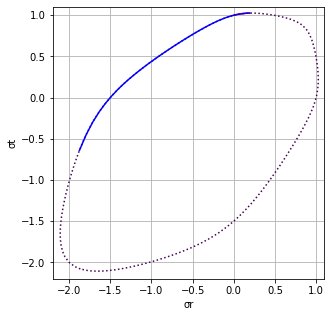

mb = 6.420364049768713, c1 = 1, c2 = 1, r0 = 0.33516994242696563

σr(c1) = -1.8742204140255896, σt(c1) = -0.6421158025016767, fF(σr(c1), σt(c1)) = -7.599314922113187e-05

<hr>Входные параметры: c1=1, pa=0, m=7.93627178

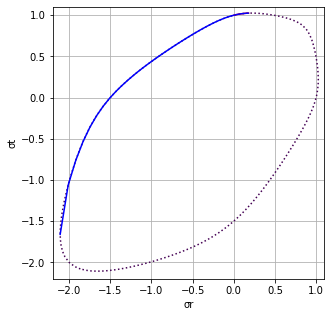

mb = 6.420364049768713, c1 = 1, c2 = 1, r0 = 0.3268925673777392

σr(c1) = -2.107808146509546, σt(c1) = -1.6609309414865074, fF(σr(c1), σt(c1)) = 1.1485624790141813e-05

In [14]:
fshow(7.420744909, 1, 0)
fshow(7.936271780, 1, 0)

<hr>Входные параметры: c1=0.5, pa=0, m=1

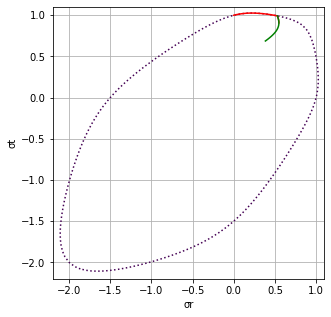

mb = 6.552316864828581, c1 = 0.5, c2 = 2.5640526467320277, r0 = 0.5998409302767594

σr(c1) = 0.528438382810329, σt(c1) = 0.9924885158535138, fF(σr(c1), σt(c1)) = -2.4537440423966217e-06

<hr>Входные параметры: c1=0.5, pa=0, m=6

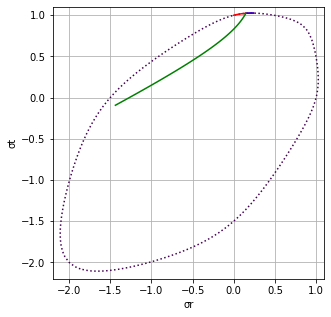

mb = 6.552316864828581, c1 = 0.5, c2 = 1.0470685272629856, r0 = 0.3621165714025912

σr(c1) = 0.14638109986537517, σt(c1) = 1.0235898912491448, fF(σr(c1), σt(c1)) = -2.3983737879040845e-06

In [15]:
fshow(1, 0.5, 0)
fshow(6, 0.5, 0)

Время, потраченное на выполнение всей программы:

<hr>Входные параметры: c1=1, pa=0, m=1

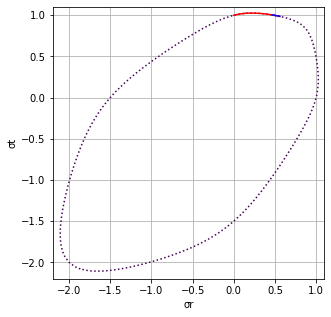

mb = 6.420364049768713, c1 = 1, c2 = 1, r0 = 0.6546928756512124

σr(c1) = 0.46824685634186225, σt(c1) = 1.003393854435111, fF(σr(c1), σt(c1)) = -2.18433834831e-06

<hr>Входные параметры: c1=1, pa=0, m=4

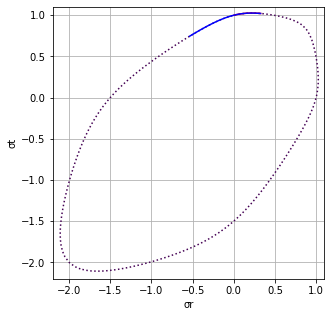

mb = 6.420364049768713, c1 = 1, c2 = 1, r0 = 0.4172062393421367

σr(c1) = -0.5352529347932095, σt(c1) = 0.7456317068108392, fF(σr(c1), σt(c1)) = -2.0224783459088513e-06

<hr>Входные параметры: c1=1, pa=0, m=4.7713

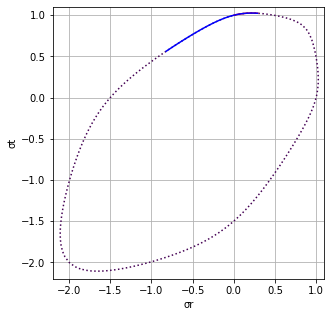

mb = 6.420364049768713, c1 = 1, c2 = 1, r0 = 0.39258865935968923

σr(c1) = -0.8209627059363166, σt(c1) = 0.5628202420537509, fF(σr(c1), σt(c1)) = -2.4729737985174083e-06

<hr>Входные параметры: c1=1, pa=0, m=6

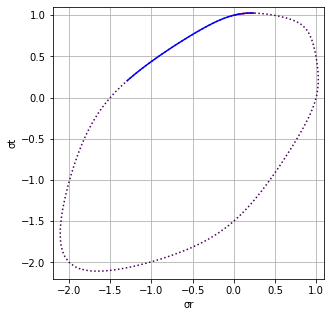

mb = 6.420364049768713, c1 = 1, c2 = 1, r0 = 0.36211657140259235

σr(c1) = -1.2936681652310835, σt(c1) = 0.20572813193278808, fF(σr(c1), σt(c1)) = -2.089715290254368e-06

<hr>Входные параметры: c1=1, pa=0, m=7

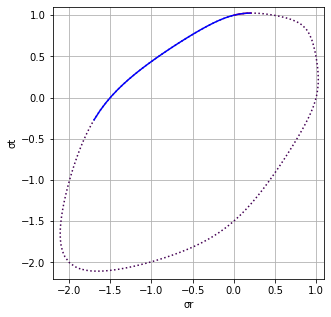

mb = 6.420364049768713, c1 = 1, c2 = 1, r0 = 0.3424636331617532

σr(c1) = -1.6961430137458426, σt(c1) = -0.2697325779325058, fF(σr(c1), σt(c1)) = -2.47557554844402e-06

<hr>Входные параметры: c1=1, pa=0, m=7.4207

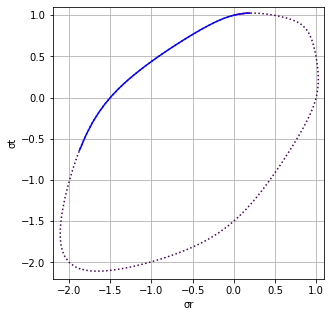

mb = 6.420364049768713, c1 = 1, c2 = 1, r0 = 0.33517069339427935

σr(c1) = -1.8742009507225716, σt(c1) = -0.6420655645667382, fF(σr(c1), σt(c1)) = -7.598004426712102e-05

In [16]:
fshow(1, 1, 0)
fshow(4, 1, 0)
fshow(4.7713, 1, 0)
fshow(6, 1, 0)
fshow(7, 1, 0)
fshow(7.4207, 1, 0)

<hr>Входные параметры: c1=0.999999999, pa=0, m=6

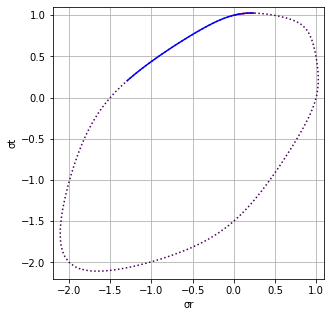

mb = 6.420165583646325, c1 = 0.999999999, c2 = 1.0000022044519523, r0 = 0.3621165714025923

σr(c1) = -1.2936681607304799, σt(c1) = 0.20572813591047806, fF(σr(c1), σt(c1)) = -2.0897152904764127e-06

<hr>Входные параметры: c1=0.9999999999, pa=0, m=6

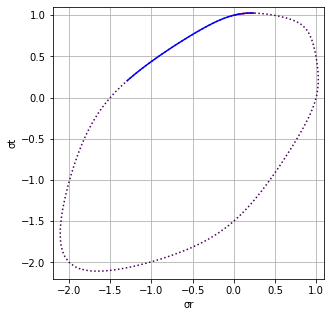

mb = 6.420344202051062, c1 = 0.9999999999, c2 = 1.0000022053519257, r0 = 0.36211657140259235

σr(c1) = -1.293668164781023, σt(c1) = 0.20572813233055715, fF(σr(c1), σt(c1)) = -2.089715290587435e-06

<hr>Входные параметры: c1=0.9999999999, pa=0, m=6

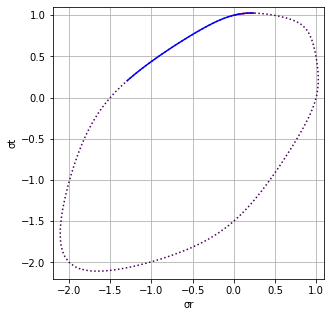

mb = 6.420344202051062, c1 = 0.9999999999, c2 = 1.0000022053519257, r0 = 0.36211657140259235

σr(c1) = -1.293668164781023, σt(c1) = 0.20572813233055715, fF(σr(c1), σt(c1)) = -2.089715290587435e-06

In [17]:
fshow(6, 0.999999999, 0)
fshow(6, 0.9999999999, 0)
fshow(6, 0.9999999999, 0)

In [18]:
display(time.time() - start_time)

64.86585521697998